# Capability Correlations and Time

In the second part of the analysis we will focus on how the global capabilities change with time. This part looks to answer one main question that can be divided into other severall research questions. 
- How does the research and innovation in a certain field change over time? 
- Are there any chronological gaps in the research throughout the years? 
[...]

### Table of Contents
- [1. Data Extraction](#one)
    - [1.1. The Years](#one-one)
    - [1.2. Co-occurence matrix for the years](#one-two)
        - [1.2.1. Getting the labels](#one-two-one)
        - [1.2.2. Function](#one-two-two)
- [2. Analysis](#two)
    - [2.1. Year Profiles](#two-one)
    - [2.2. Correlation Matrix](#two-two)
        - [2.2.1. Considerations](#two-two-one)
        - [2.2.2. Final co-ocurrence matrix](#two-two-two)
        - [2.2.3. Heatmap Clustering](#two-two-three)
    - [2.3. Correlation Over Time](#two-three)
    - [2.4. Research details over time](#two-four)
        - [2.4.1. Outputs](#two-four-one)
        - [2.4.2. Processing technologies](#two-four-two)
        - [2.4.3. Feedstock](#two-four-three)
    - [2.5. Contextual Relationships](#two-five)


## 1. Data Extraction <a class="anchor" id="one"></a>

Let's start by importing all of the external libraries that will be useful during the analysis. 

In [1]:
from py2neo import Graph
import numpy as np 
from pandas import DataFrame
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import pandas as pd
import plotly 
import plotly.graph_objs as go
import qgrid
from scipy import stats, spatial
from sklearn.cluster.bicluster import SpectralBiclustering
import operator

# connection to Neo4j
local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = Graph(local_connection_url)

# plotly credentials
plotly_config = json.load(open('plotly_config.json'))
plotly.tools.set_credentials_file(username=plotly_config['username'], api_key=plotly_config['key'])

### 1.1. The Years <a class="anchor" id="one-one"></a>

Not all years in the Neo4j databse contain technological assets. For this reason, two lists will be created. A completely chronological one and a database one. 

In [2]:
# query years
years_available_q = """     MATCH (n:Asset)
                            WITH n.year as YEAR
                            RETURN YEAR, count(YEAR)
                            ORDER BY YEAR ASC """

# create a list with the years where records exist
years_available = DataFrame(connection_to_graph.data(years_available_q)).as_matrix()[:, 0][:-1]
years_available = [int(year) for year in years_available]

# create a pure range list
first_year = int(years_available[0])
last_year = int(years_available[-1])
real_years = range(first_year, last_year + 1, 1)

# give information 
print 'The database list starts in {}, ends in {} and contains {} years.'.format(years_available[0], years_available[-1], len(years_available))
print 'The real list starts in {}, ends in {} and contains {} years.'.format(real_years[0], real_years[-1], len(real_years))

The database list starts in 1938, ends in 2019 and contains 38 years.
The real list starts in 1938, ends in 2019 and contains 82 years.


Now that we have all of the years available, we can start building the technological capability matrixes, with a similar process to what was previsouly done. 

### 1.2. Co-occurence matrix for the years <a class="anchor" id="one-two"></a>

#### 1.2.1. Getting the labels <a class="anchor" id="one-two-one"></a>

We start by importing a few methods from the previous notebook. 

In [3]:
def find_index(something, in_list):
    return in_list.index(something)

Let's first get all of the axis that our matrixes will take.

We start by designing two queries that will help us get all of the labels of the matrix. 

The labels of the non intersecting part: 

In [4]:
q_noInter_axis = """    MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                        MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                        MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                        RETURN fs.term, pt.term, out.term, count(a)
                                """

feedstocks = np.unique(DataFrame(connection_to_graph.data(q_noInter_axis)).as_matrix()[:, 1]).tolist()
proc_tech = np.unique(DataFrame(connection_to_graph.data(q_noInter_axis)).as_matrix()[:, 2]).tolist()
output = np.unique(DataFrame(connection_to_graph.data(q_noInter_axis)).as_matrix()[:, 3]).tolist()

axis_names = feedstocks + proc_tech + output 
print 'The axis list has {} terms.'.format(len(axis_names))

The axis list has 289 terms.


The labels of the intersecting part:

In [5]:
q_Inter_axis = """  MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                    MATCH (a:Asset)-[:CONTAINS]->(t:{})
                    WHERE fs<>t 
                    RETURN fs.term, t.term, count(a)
                                    """
process_variables = ['Feedstock', 'Output', 'ProcessingTech']

# Extra labels that only appear in non-intersection queries
for category in process_variables:
    data_no_intersections = DataFrame(connection_to_graph.data(q_Inter_axis.format(category, category))).as_matrix()
    for column_number in range(1,3):
        column = data_no_intersections[:, column_number]
        for name in column:
            if name not in axis_names:
                axis_names.append(name)

print 'The axis list has {} terms.'.format(len(axis_names))                

The axis list has 342 terms.


#### 1.2.2. Function <a class="anchor" id="one-two-two"></a>

We start by creating a function that given a certain year, returns the year's capability matrix. 

In [6]:
def get_year_matrix(year, normalization=True):
    
    # define queries
    q1 = """   MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                WHERE a.year = "{}"
                RETURN fs.term, pt.term, out.term, count(a)
                                    """.format(year)
    
    process_variables = ['Feedstock', 'Output', 'ProcessingTech']
    
    q2 = """   MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                MATCH (a:Asset)-[:CONTAINS]->(t:{})
                WHERE fs<>t AND a.year = "{}"
                RETURN fs.term, t.term, count(a)
                                    """
    # get data
    data_q1 = DataFrame(connection_to_graph.data(q1)).as_matrix()
    
    # create matrix
    year_matrix = np.zeros([len(axis_names), len(axis_names)])
    
    # for no intersections data
    for row in data_q1:
        # the last column is the frequency (count)
        frequency = row[0]
        indexes = [find_index(element, axis_names) for element in row[1::]]
        # add frequency value to matrix position not inter
        for pair in itertools.combinations(indexes, 2):
            year_matrix[pair[0], pair[1]] += frequency
            year_matrix[pair[1], pair[0]] += frequency
    
    # for intersecting data
    for category in process_variables:
        process_data = DataFrame(connection_to_graph.data(q2.format(category, category, year))).as_matrix()
        for row in process_data:
            frequency = row[0]
            indexes = [find_index(element, axis_names) for element in row[1::]]
            # add frequency value to matrix position inter
            for pair in itertools.combinations(indexes, 2):
                year_matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
                year_matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized
    
    # normalize
    norm_year_matrix = (year_matrix - np.mean(year_matrix)) / np.std(year_matrix)
    
    # dynamic return 
    if normalization == True:
        return norm_year_matrix
    else: 
        return year_matrix

We finally test our function with the year 2016. 

In [7]:
year = 2016
print 'The matrix from {} has shape {} a max value of {}, a min value of {} and a mean of {}.'.format(year, get_year_matrix(year).shape, np.amax(get_year_matrix(year)), np.amin(get_year_matrix(year)), np.mean(get_year_matrix(year)))

The matrix from 2016 has shape (342, 342) a max value of 94.0056982009, a min value of -0.0794170079582 and a mean of 1.02058051715e-17.


## 2. Analysis <a class="anchor" id="two"></a>

In order to analyse the correlation of the years between themselves, we will need to transform each year matrix into a list. Since the matrix is symmetrical, we will only need the upper triangle. For programming reasons, we have designed our own upper triangulization matrix. 

In [8]:
def get_list_from(matrix):
    only_valuable = []
    extension = 1
    for row_number in range(matrix.shape[0]):
        only_valuable.append(matrix[row_number, extension:matrix.shape[0]].tolist()) # numpy functions keep 0s so I hard coded it. 
        extension += 1 
    return [element for column in only_valuable for element in column ]

### 2.1. Year Profiles <a class="anchor" id="two-one"></a>

Let's visualize the correlation between two years and their capability arrays. 

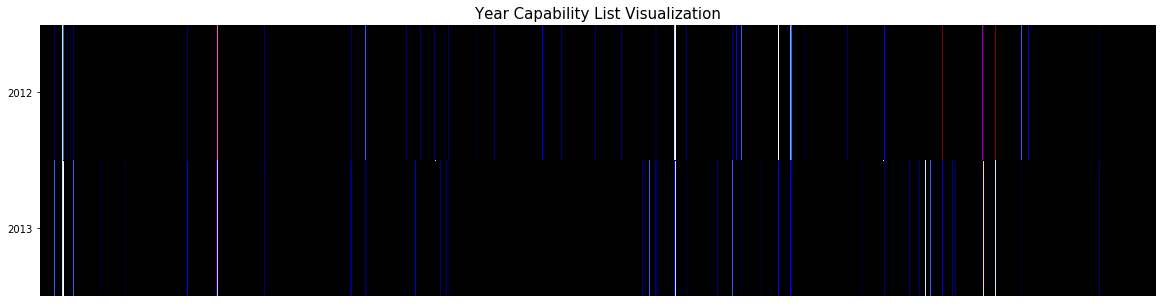

The pearson correlation index between the two years is: 0.902580296089 (P-value of 0.0)


In [9]:
# apply functions to both countries
a_list = get_list_from(get_year_matrix(2012, normalization=True))
b_list = get_list_from(get_year_matrix(2013, normalization=True))

# create a matrix where each row is a list of a country
corelation = np.vstack((a_list, b_list))

# plot the matrix 
plt.subplots(1,1,figsize=(20, 5))
plt.subplot(111)
sns.heatmap(corelation, cmap='flag_r', cbar=None, square=False, yticklabels=['2012', '2013'], xticklabels=False)
plt.yticks(rotation=0)
plt.title('Year Capability List Visualization', size=15)
plt.show()

print 'The pearson correlation index between the two years is: {} (P-value of {})'.format(stats.pearsonr(a_list, b_list)[0], stats.pearsonr(a_list, b_list)[1])

It is already apparent that these two consecutive years are highly correlated.

### 2.2. Correlation Matrix <a class="anchor" id="two-two"></a>

#### 2.2.1. Considerations <a class="anchor" id="two-two-one"></a>

As previously done with countries, a year correlation matrix will be built. 

We first define the scope of the matrix.

In [10]:
number_of_years = len(years_available)
years_in_matrix = years_available
years_correlation = np.zeros([number_of_years, number_of_years])
print years_in_matrix

[1938, 1975, 1980, 1981, 1983, 1985, 1986, 1988, 1989, 1990, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


And we build the matrix

In [11]:
data = np.load('Data/year_capability_dict.npy').item()
for row in range(number_of_years):
    print 'Processing year {} / {} ({})\r'.format(row + 1, number_of_years, years_in_matrix[row]),
    year_1_list = data[years_in_matrix[row]]
    for column in range(number_of_years):
        
        year_2_list = data[years_in_matrix[column]]

        years_correlation[row, column] = stats.pearsonr(year_1_list, year_2_list)[0]
        

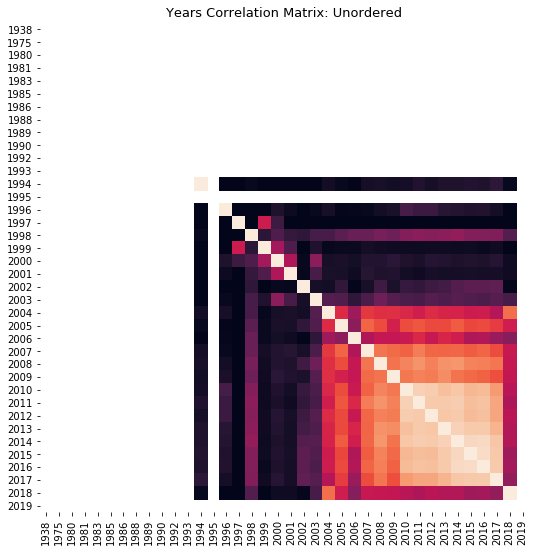

In [12]:
plt.subplots(1,1,figsize=(9, 9))
plt.subplot(111)
sns.heatmap(years_correlation, cbar=False, square=True, yticklabels=years_in_matrix, xticklabels=years_in_matrix)
plt.title('Years Correlation Matrix: Unordered', size=13)
plt.show()

There seems to be a lot of data missing. 

Let's plot the amount of records in our databse over time to get a better sense on how to approach the problem.

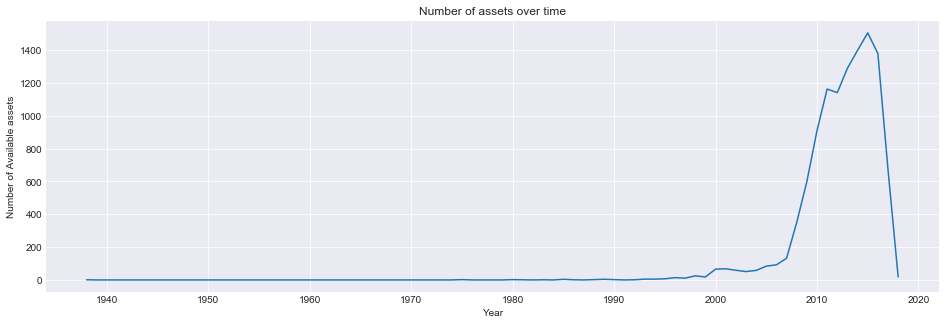

In [13]:
# get all of the data
data = DataFrame(connection_to_graph.data(years_available_q)).as_matrix()
raw = [int(a) for a in data[:-1, 0]]
timeline = range(min(raw), max(raw))
qtties = []

# build a timeline and number of records. 
for year in timeline:
    if year not in raw:
        qtties.append(0)
    else: 
        idx = find_index(str(year), list(data[:, 0]))
        qtties.append(data[idx, 1])

# plot the graph
plt.style.use('seaborn-darkgrid')
plt.subplots(1,1,figsize=(16, 5))
plt.subplot(111)
plt.title("Number of assets over time")
plt.xlabel("Year")
plt.ylabel("Number of Available assets")
plt.plot(timeline, qtties)
plt.show()

#### 2.2.2. Final co-ocurrence matrix <a class="anchor" id="two-two-two"></a>

To counteract the fact that our dataset is not uniformily distributed across the years, we will only consider the last 15 years. [2004-2018]

In [14]:
number_of_years = 15
years_in_matrix = years_available[:-1][-number_of_years:]
years_correlation = np.zeros([number_of_years, number_of_years])

We now rebuild and plot the heatmaop of correlations. 

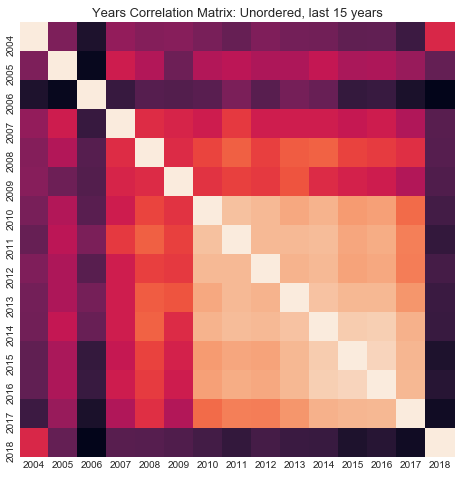

In [15]:
data = np.load('Data/year_capability_dict.npy').item()
for row in range(number_of_years):
    print 'Processing year {} / {} ({})\r'.format(row + 1, number_of_years, years_in_matrix[row]),
    year_1_list = data[years_in_matrix[row]]
    for column in range(number_of_years):        
        year_2_list = data[years_in_matrix[column]]
        years_correlation[row, column] = stats.pearsonr(year_1_list, year_2_list)[0]

plt.subplots(1,1,figsize=(8, 8))
plt.subplot(111)
sns.heatmap(years_correlation, cbar=False, square=True, yticklabels=years_in_matrix, xticklabels=years_in_matrix)
plt.title('Years Correlation Matrix: Unordered, last 15 years', size=13)
plt.show()

#### 2.2.3. Heatmap Clustering <a class="anchor" id="two-two-three"></a>

Let us reorder the heatmap according to hierarchical clustering. 

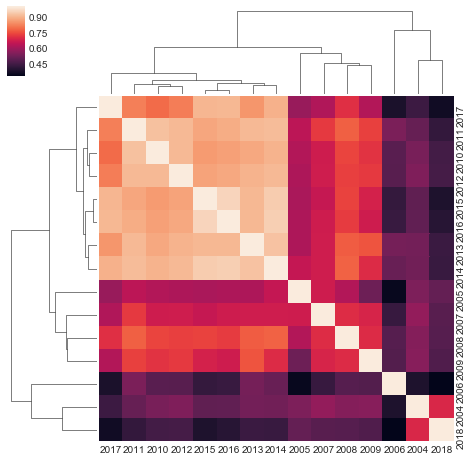

In [16]:
# plot the clustermap
a = sns.clustermap(years_correlation,  figsize=(8, 8), xticklabels = years_in_matrix, yticklabels=years_in_matrix)
plt.show()

### 2.3. Correlation Over Time <a class="anchor" id="two-three"></a>

Let us see how related is each year in our matrx with the one before it. In this way we might more easily detect discripancies. 


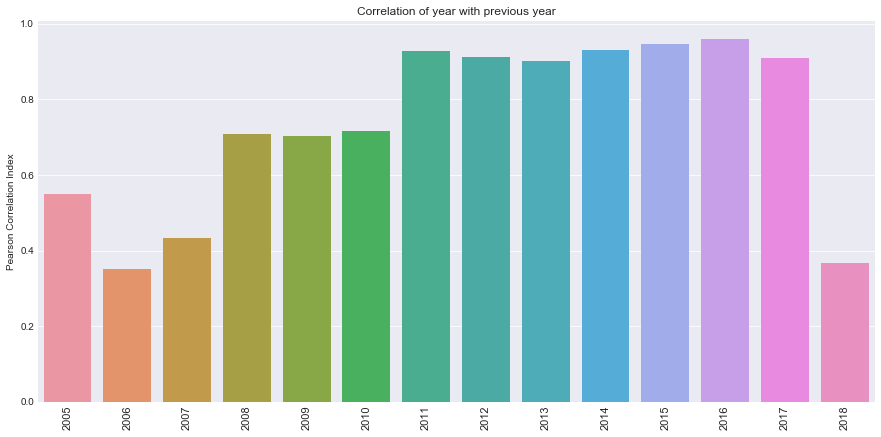

In [17]:
# remove first year
advanced_timeline = years_in_matrix[1::]
corr_with_pre = []

row = 1
col = 0
for year in advanced_timeline:
    corr_with_pre.append(years_correlation[row, col])
    row = row + 1
    col = col + 1

plt.subplots(1,1,figsize=(15,7))
sns.barplot(np.arange(len(corr_with_pre)), corr_with_pre )
plt.xticks(np.arange(len(corr_with_pre)), advanced_timeline, rotation=90, fontsize=11)
plt.title('Correlation of year with previous year')
plt.ylabel('Pearson Correlation Index')
plt.show()

Some years, such as 2006 or 2007 appear to have very low correlations with the years after. There seems to be an overall tendency of augmenting correlation with the years. 

### 2.4. Research details over time <a class="anchor" id="two-four"></a>

The following part of the analysis wil focus on how certain process variables (Feedstocks, Processing Technologies and Outputs) evolve over time.

This can help in answering questions such as for example:

- Is the focus on a certain processing technology constant over time?
- Is this evolution correlated with other external factors? 

Let's start by creating a function such as: 

f(term, type of process variable) = [array with the number of records containing the term in each year]

*Note: The records returned will only be related to [2010;2017] for consistency purposes.*

In [18]:
def get_records_of(term, process_type, normalization=True, table=False):
    # make query 
    query = """ MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                WHERE fs.term = "{}"
                AND (toInteger(a.year)<=2017 AND toInteger(a.year)>=2010) 
                AND NOT a.year = "Null"
                RETURN  a.year, count(a)
                ORDER BY a.year   """.format(process_type, term)
    # access desired row
    data = list(DataFrame(connection_to_graph.data(query)).as_matrix()[:, 1])
    if table is True:
        return DataFrame(connection_to_graph.data(query)).as_matrix()
    
    if normalization is True:
        return [float(i)/sum(data) for i in data]
    else:
        return data 

Now that the function is built, we can plot virtually any evolution.  

#### 2.4.1. Outputs <a class="anchor" id="two-four-one"></a>

Let us see the evolution of records of biogas Vs. ethanol as an example.

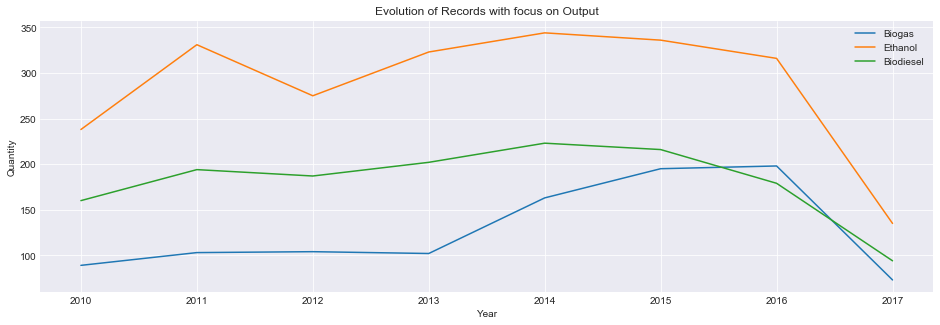

In [19]:
# plot the graph
plt.style.use('seaborn-darkgrid')
plt.subplots(1,1,figsize=(16, 5))
plt.subplot(111)
plt.title("Evolution of Records with focus on Output")
plt.xlabel("Year")
plt.ylabel("Quantity")
plt.plot(range(2010, 2018), get_records_of('biogas', 'Output', normalization=False), label='Biogas')
plt.plot(range(2010, 2018), get_records_of('ethanol', 'Output', normalization=False), label='Ethanol')
plt.plot(range(2010, 2018), get_records_of('biodiesel', 'Output', normalization=False), label='Biodiesel')
plt.xticks(range(2010, 2018), [str(a) for a in range(2010, 2018)])
plt.legend()
plt.show()

#### 2.4.2. Processing technologies <a class="anchor" id="two-four-two"></a>

Let us develop the same procedure for some processign technologies.

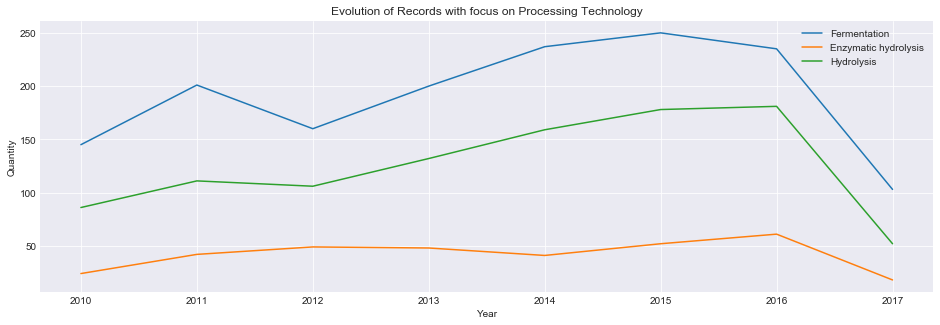

In [20]:
# plot the graph
plt.style.use('seaborn-darkgrid')

plt.subplots(1,1,figsize=(16, 5))
plt.subplot(111)
plt.title("Evolution of Records with focus on Processing Technology")
plt.xlabel("Year")
plt.ylabel("Quantity")
plt.plot(range(2010, 2018),get_records_of('fermentation', 'ProcessingTech', normalization=False), label="Fermentation")
plt.plot(range(2010, 2018),get_records_of('enzymatic hydrolysis', 'ProcessingTech', normalization=False), label="Enzymatic hydrolysis")
plt.plot(range(2010, 2018),get_records_of('hydrolysis', 'ProcessingTech', normalization=False), label="Hydrolysis")
plt.xticks(range(2010, 2018), [str(a) for a in range(2010, 2018)])
plt.legend()
plt.show()

#### 2.4.3. Feedstock <a class="anchor" id="two-four-three"></a>

Let us develop the same procedure for feedstock.

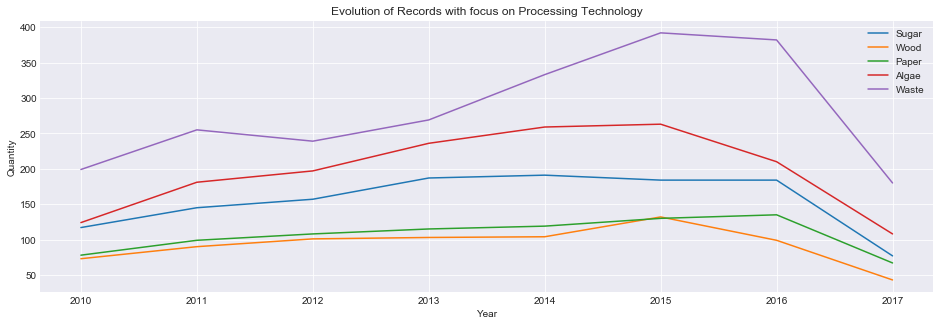

In [21]:
# plot the graph
plt.style.use('seaborn-darkgrid')
plt.subplots(1,1,figsize=(16, 5))
plt.subplot(111)
plt.title("Evolution of Records with focus on Processing Technology")
plt.xlabel("Year")
plt.ylabel("Quantity")
plt.plot(range(2010, 2018),get_records_of('sugar', 'Feedstock', normalization=False), label="Sugar")
plt.plot(range(2010, 2018),get_records_of('wood', 'Feedstock', normalization=False), label="Wood")
plt.plot(range(2010, 2018),get_records_of('paper', 'Feedstock', normalization=False), label="Paper")
plt.plot(range(2010, 2018),get_records_of('algae', 'Feedstock', normalization=False), label="Algae")
plt.plot(range(2010, 2018),get_records_of('waste', 'Feedstock', normalization=False), label="Waste")
plt.xticks(range(2010, 2018), [str(a) for a in range(2010, 2018)])
plt.legend()
plt.show()

### 2.5. Contextual Relationships <a class="anchor" id="two-five"></a>

#### 2.5.1. US Regular Conventional Gas Price  <a class="anchor" id="two-five-one"></a>

We start by comparing the evolution of the outputs above studied with the average oil price per gallon found in the [following](https://fred.stlouisfed.org/series/GASREGCOVM#0) website.

We import the data:

In [22]:
oil_data = pd.read_csv('Data/Oil_per_gallon.csv', delimiter=';', header=None).as_matrix()
oil_prices = list(oil_data[:, 1])

And build a graph: 

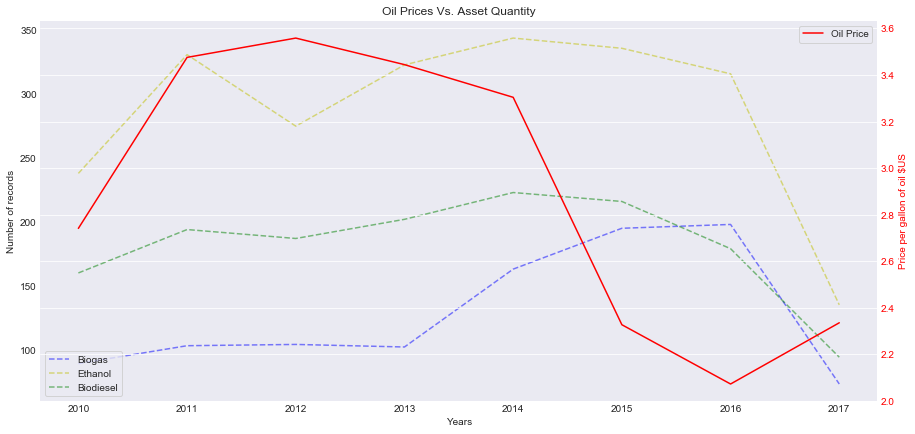

The pearson correlation between oil prices and biodiesel assets is 0.425936292026 and has a p-value of 0.292704873456.


In [36]:
# define subplots
fig, ax1 = plt.subplots(figsize=(15,7))

# first axis
ax1.plot(range(2010, 2018), get_records_of('biogas', 'Output', normalization=False), label='Biogas', color='b', ls='--', alpha=0.5)
ax1.plot(range(2010, 2018), get_records_of('ethanol', 'Output', normalization=False), label='Ethanol', color='y', ls='--', alpha=0.5)
ax1.plot(range(2010, 2018), get_records_of('biodiesel', 'Output', normalization=False), label='Biodiesel', color='g', ls='--', alpha=0.5)
ax1.set_xlabel('Years')
ax1.set_ylabel('Number of records')
ax1.tick_params('y')
ax1.set_title('Oil Prices Vs. Asset Quantity')
ax1.legend(loc=3, frameon=True)
ax1.grid(False)

# second axis
ax2 = ax1.twinx()
ax2.plot(range(2010, 2018),oil_prices, color='r', label='Oil Price')
ax2.set_ylabel('Price per gallon of oil $US', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc=1, frameon=True)

# expose
plt.show()

# print pearson correlation index
chosen_output = 'biodiesel'
oil_corr = stats.pearsonr(get_records_of(chosen_output, 'Output', normalization=False), oil_prices)
print 'The pearson correlation between oil prices and {} assets is {} and has a p-value of {}.'.format(chosen_output, oil_corr[0], oil_corr[1])

#### 2.5.2. Sugar Cost  <a class="anchor" id="two-five-two"></a>

In this part we will make the same analysis but taking an example of a feedstock: sugar. 

Data was obtained [here.](http://databank.worldbank.org/data/reports.aspx?source=global-economic-monitor-commodities#)

We start by importing the data. 

In [24]:
sugar_data = pd.read_csv('Data/Sugar_Price_csv', delimiter=';', header=None).as_matrix()
sugar_prices = list(sugar_data[:, 1])

And we plot the results. 

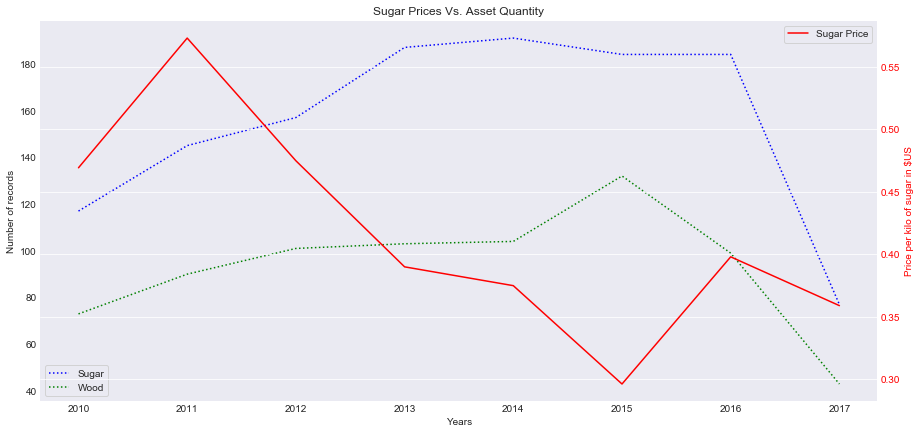

The pearson correlation between sugar prices and sugar assets is -0.218492436865 and has a p-value of 0.60317819924.


In [37]:
# define subplots
fig, ax1 = plt.subplots(figsize=(15,7))

# first axis
ax1.plot(range(2010, 2018), get_records_of('sugar', 'Feedstock', normalization=False), label='Sugar', color='b', ls=':', alpha=1)
ax1.plot(range(2010, 2018), get_records_of('wood', 'Feedstock', normalization=False), label='Wood', color='g', ls=':', alpha=1)
ax1.set_xlabel('Years')
ax1.set_ylabel('Number of records')
ax1.tick_params('y')
ax1.set_title('Sugar Prices Vs. Asset Quantity')
ax1.legend(loc=3, frameon=True)
ax1.grid(False)

# second axis
ax2 = ax1.twinx()
ax2.plot(range(2010, 2018),sugar_prices, color='r', label='Sugar Price', ls='-')
ax2.set_ylabel('Price per kilo of sugar in $US', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc=1, frameon=True)

# expose
plt.show()

# print pearson correlation index
chosen_feed = 'sugar'
sug_corr = stats.pearsonr(get_records_of(chosen_feed, 'Feedstock', normalization=False), sugar_prices)
print 'The pearson correlation between sugar prices and {} assets is {} and has a p-value of {}.'.format(chosen_feed, sug_corr[0], sug_corr[1])